## Imports

In [29]:
from data.Data import Data

from models.NaiveBayes import NaiveBayes
from models.RandomModel import RandomModel
from models.NeuralNetwork import NeuralNetwork
from models.XGBoost import XGBoost
from models.RandomForest import RandomForest
from models.SupportVectorMachine import SupportVectorMachine

from model_evaluator.ModelEvaluator import ModelEvaluator

import random
import pandas as pd
import numpy as np
import os
import time

from matplotlib import pyplot as plt
from math import ceil

# Seed

In [30]:
seed = None
if not seed:
    seed = random.randint(0, 99999)
print(f"SEED: {seed}")

np.random.seed(seed=seed)
random.seed(seed)

SEED: 70785


## Cutoff for ROC calculation

In [31]:
CUTOFFS = np.arange(0, 1, 0.02)

## Data

In [32]:
dataset = "breast-cancer-wisconsin"
COLUMNS_FOR_BREAST_CANCER = ['node-caps', 'inv-nodes', 'tumor-size', 'deg-malig', 'irradiat', 'class']

distinct_columns = None
if dataset == "breast-cancer":
  distinct_columns = COLUMNS_FOR_BREAST_CANCER

data = Data(dataset, distinct_columns=distinct_columns)

train, eval = data.get_train_and_valid_set(0.7)

train_x = train.drop('class', axis=1)
train_y = train['class']

eval_x = eval.drop('class', axis=1)
eval_y = eval['class']

# Check class disproportion

In [33]:
print(f"train_0: {len(train[train['class'] == 0])}, train_1: {len(train[train['class'] == 1])}")
print(f"test_0: {len(eval[eval['class'] == 0])}, test_1: {len(eval[eval['class'] == 1])}")

train_0: 328, train_1: 161
test_0: 130, test_1: 80


## Models

In [34]:
MODELS_DIR = "./model_saves"

nn_models_dir = os.path.join(MODELS_DIR, "nn_models_saves")
xgb_models_dir = os.path.join(MODELS_DIR, "xgb_models_saves")

In [35]:
models = [
    RandomModel(),
    NaiveBayes(),
    NeuralNetwork(len(train_x.columns)),
    RandomForest(),
    XGBoost(),
    SupportVectorMachine()
]

## Train models

In [36]:
exec_times = {}
for model in models:
    start = time.time()
    model.fit(train_x, train_y)
    end = time.time()
    exec_times[model.name] = end - start


0 tensor(0.0008, grad_fn=<DivBackward0>)
1 tensor(0.0003, grad_fn=<DivBackward0>)
2 tensor(0.0002, grad_fn=<DivBackward0>)
3 tensor(0.0002, grad_fn=<DivBackward0>)
4 tensor(0.0001, grad_fn=<DivBackward0>)
5 tensor(0.0002, grad_fn=<DivBackward0>)
6 tensor(0.0004, grad_fn=<DivBackward0>)
7 tensor(0.0003, grad_fn=<DivBackward0>)
8 tensor(0.0003, grad_fn=<DivBackward0>)
9 tensor(0.0002, grad_fn=<DivBackward0>)
10 tensor(0.0003, grad_fn=<DivBackward0>)
11 tensor(0.0002, grad_fn=<DivBackward0>)
12 tensor(0.0003, grad_fn=<DivBackward0>)
13 tensor(0.0004, grad_fn=<DivBackward0>)
14 tensor(0.0003, grad_fn=<DivBackward0>)
15 tensor(0.0002, grad_fn=<DivBackward0>)
16 tensor(0.0002, grad_fn=<DivBackward0>)
17 tensor(0.0001, grad_fn=<DivBackward0>)
18 tensor(0.0002, grad_fn=<DivBackward0>)
19 tensor(0.0003, grad_fn=<DivBackward0>)
20 tensor(0.0002, grad_fn=<DivBackward0>)
21 tensor(0.0002, grad_fn=<DivBackward0>)
22 tensor(0.0004, grad_fn=<DivBackward0>)
23 tensor(0.0002, grad_fn=<DivBackward0>)
24

c:\Users\hrzon\anaconda3\envs\ssne-env-python-3-7\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


## Calculate models metrics

In [37]:
model_evals = {
   model.name: ModelEvaluator(model) for model in models
}

In [38]:
for name, model_eval in model_evals.items():
    model_eval.calculate_quality(eval_x, np.array(eval_y))

## Results

In [39]:
for name, model_eval in model_evals.items():
    print(model_eval)

BinaryClassificationModel: RandomModel
Confusion Matrix: 
[[39 58]
 [41 72]]
Accuracy: 0.5285714285714286
Recall(also known as Sensitivity): 0.4875
Specificity: 0.5538461538461539
Precision: 0.4020618556701031
F1 Score: 0.44067796610169496
Support: 80

BinaryClassificationModel: NaiveBayes
Confusion Matrix: 
[[ 78   7]
 [  2 123]]
Accuracy: 0.9571428571428572
Recall(also known as Sensitivity): 0.975
Specificity: 0.9461538461538461
Precision: 0.9176470588235294
F1 Score: 0.9454545454545454
Support: 80

BinaryClassificationModel: NeuralNetwork
Confusion Matrix: 
[[ 78   4]
 [  2 126]]
Accuracy: 0.9714285714285714
Recall(also known as Sensitivity): 0.975
Specificity: 0.9692307692307692
Precision: 0.9512195121951219
F1 Score: 0.9629629629629629
Support: 80

BinaryClassificationModel: RandomForest
Confusion Matrix: 
[[ 76   4]
 [  4 126]]
Accuracy: 0.9619047619047619
Recall(also known as Sensitivity): 0.95
Specificity: 0.9692307692307692
Precision: 0.95
F1 Score: 0.9500000000000001
Support:

## Results

### ROC curves

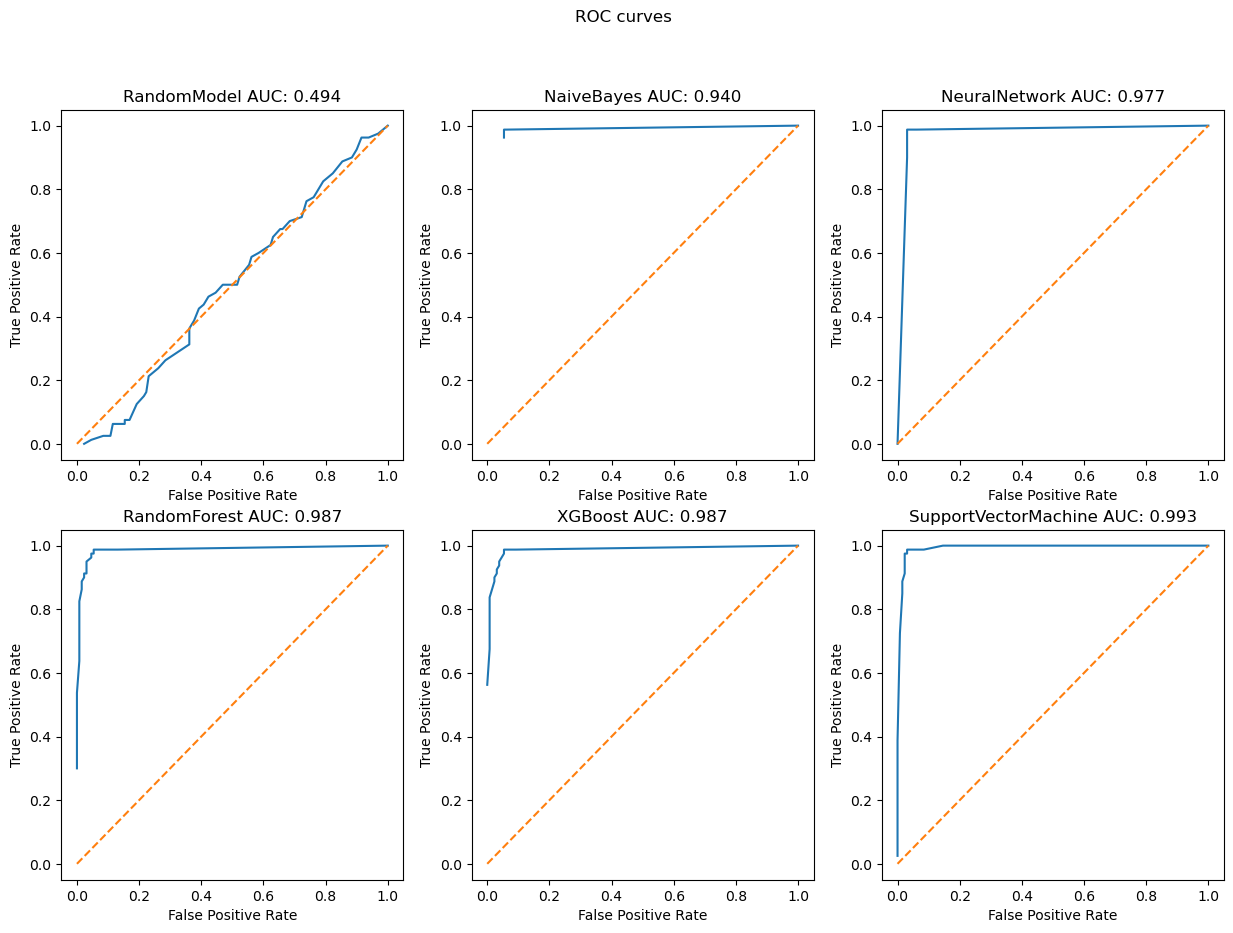

In [40]:
fig, axs = plt.subplots(2, ceil(len(models)/2))
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('ROC curves')
for model_eval, ax in zip(model_evals.values(), axs.flatten()):
    model_eval.plot_roc_curve(ax, eval_x, np.array(eval_y), CUTOFFS)
plt.show()

# Confusion matrices

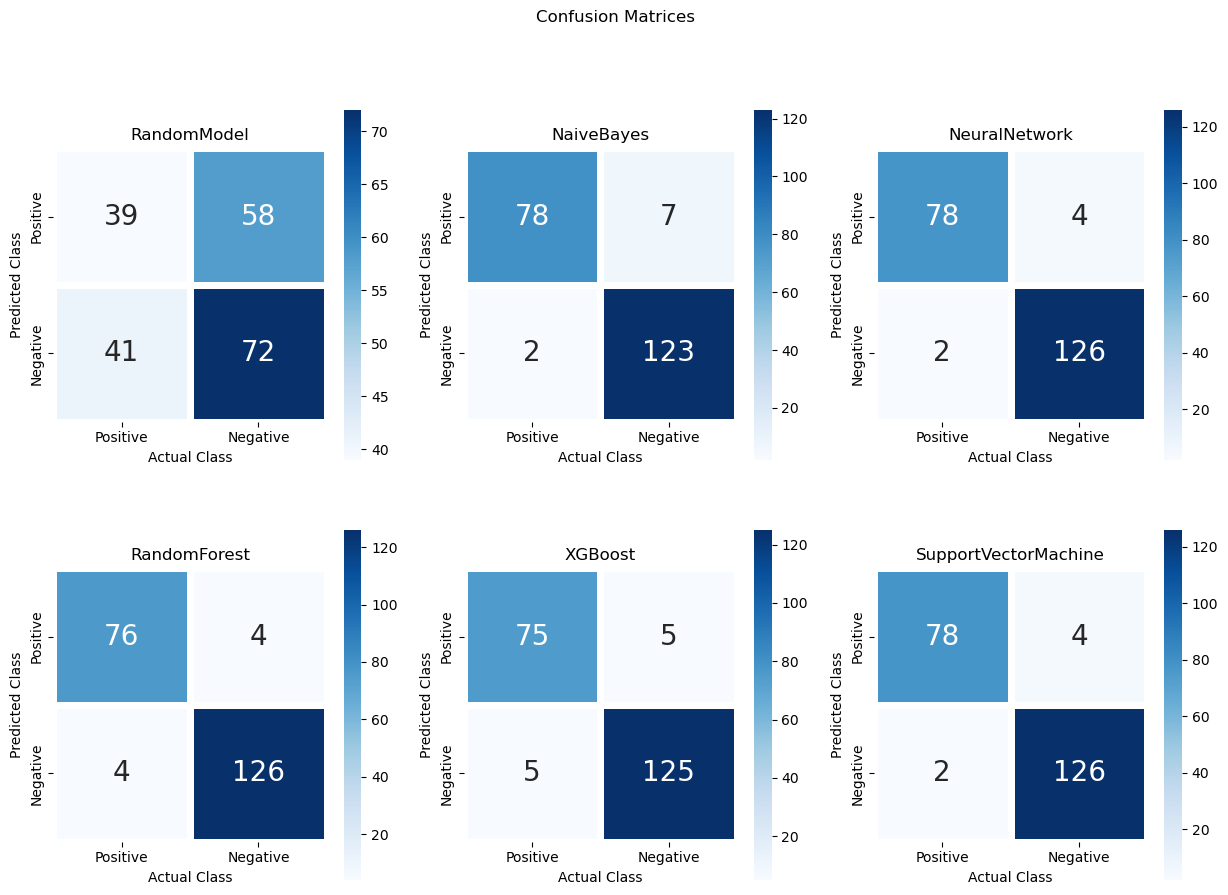

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [41]:
fig, axs = plt.subplots(2, ceil(len(models)/2))
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('Confusion Matrices')
for model_eval, ax in zip(model_evals.values(), axs.flatten()):
    model_eval.plot_confusion_matrix(ax)
plt.show()

In [42]:
results = pd.DataFrame(columns=['model', 'accuracy', 'recall(sensitvity)', 'specificity', 'precision', 'f1_score', 'support', 'auc'])

for name, model in model_evals.items():
    
    results = results.append({'model' : name,
                            'accuracy' : model.get_accuracy(), 
                            'recall(sensitvity)' : model.get_recall(), 
                            'specificity' : model.get_specificity(), 
                            'precision' : model.get_precision(), 
                            'f1_score' : model.get_f1_score(), 
                            'support' : model.get_support(), 
                            'auc' : model.get_auc(),
                            'execution time' : exec_times[name]}, 
                            ignore_index=True)
results


,model,accuracy,recall(sensitvity),specificity,precision,f1_score,support,auc,execution time
0,RandomModel,0.528571,0.4875,0.553846,0.402062,0.440678,80,0.494423,0.000000
1,NaiveBayes,0.957143,0.9750,0.946154,0.917647,0.945455,80,0.940192,0.002000
2,NeuralNetwork,0.971429,0.9750,0.969231,0.951220,0.962963,80,0.976827,11.707561
3,RandomForest,0.961905,0.9500,0.969231,0.950000,0.950000,80,0.986875,0.548198
4,XGBoost,0.952381,0.9375,0.961538,0.937500,0.937500,80,0.986971,0.131013
5,SupportVectorMachine,0.971429,0.9750,0.969231,0.951220,0.962963,80,0.992933,0.021005


W NN i XGBoost może wyjść zerowy execution time, jest tak gdyż korzystamy z pretrenowanych modeli

# ANALIZA ISTOTNOŚCI ATRYBUTÓW DLA SIECI NEURONOWYCH

### Wsp Shapleya

In [ ]:
import shap

===[ Model: RandomModel ]===


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


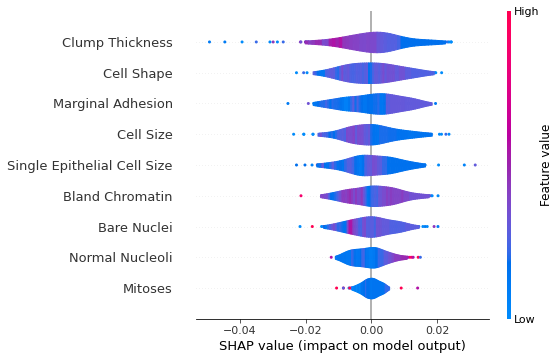

===[ Model: NaiveBayes ]===


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


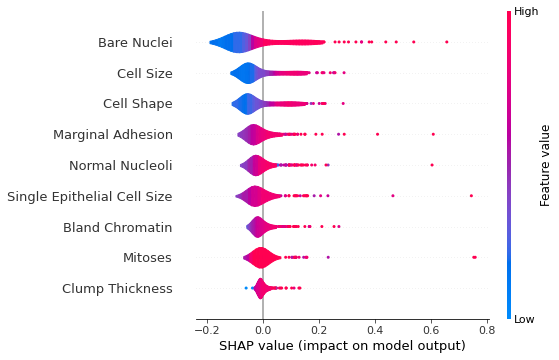

Exact explainer: 211it [02:12,  1.48it/s]                         


===[ Model: NeuralNetwork ]===


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


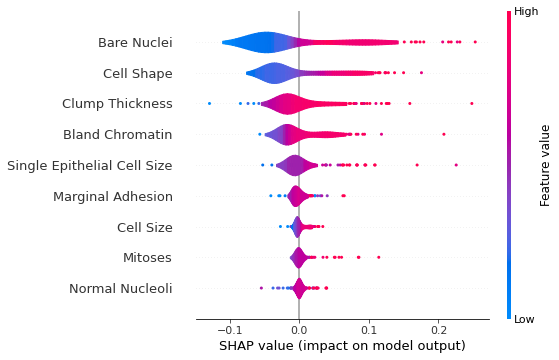

Exact explainer: 211it [04:44,  1.39s/it]                         


===[ Model: RandomForest ]===


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


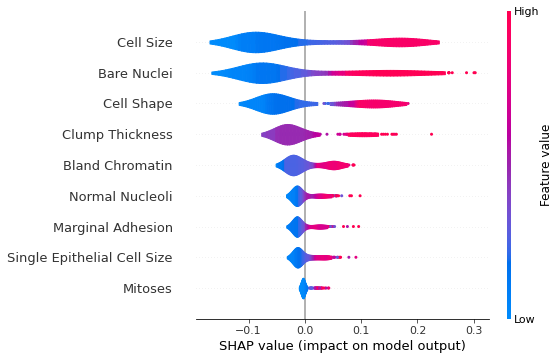

===[ Model: XGBoost ]===


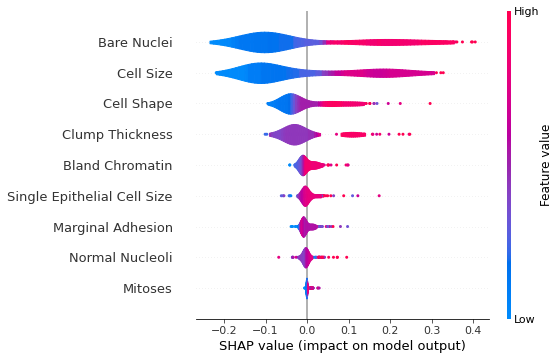

Exact explainer: 211it [01:29,  2.13it/s]                         


===[ Model: SupportVectorMachine ]===


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


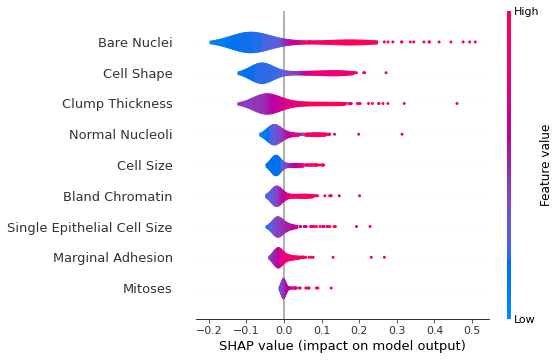

In [ ]:
for name, model_eval in model_evals.items():
  model = model_eval.model
  # Fits the explainer
  explainer = shap.Explainer(model.predict, eval_x)
  # Calculates the SHAP values - It takes some time
  shap_values = explainer(eval_x)
  print(f"===[ Model: {name} ]===")
  shap.summary_plot(shap_values, plot_type='violin')

 ## Analiza wyników

### Wstępne założenia
W naszym zadaniu samo accuracy nie będzie dobrym wyznacznikiem jakości modelu. Ważne
będzie, aby przy ocenie wziąć pod uwagę Sensitivity oraz Specificty. To, aby ustalić która z
tych dwóch metryk jest ważniejsza, musi odpowiedzieć pytanie czy jesteśmy bardziej skłonni
dopuścić do klasyfikacji przypadków fałszywie negatywnych, czy fałszywie pozytywnych. Oso
biście zdaje mi się, że większe straty ponosimy w przypadku klasyfikacji FN, przypadki FP
zawsze można wykluczyć w dogłębnym badaniu, na przykład sięgając po opinię specjalistów
lub innego algorytmu. Dlatego zdaje mi się, że specificity będzie w tym problemie ważniej
szą metryką. Dodatkowo dobrymi miarami do porównania algorytmów będzie miara F1 oraz
krzywe ROC i AUC.

### !!! Pełna analiza w sprawozdaniu !!!
